金融市场数据是非常嘈杂的，因为它受到许多不同的因素影响，例如政治、经济和社会事件等。这些因素可能导致价格波动和不确定性，使得数据分析变得更加困难。

对金融市场数据进行平滑处理可以减少噪音、揭示趋势和降低风险，从而帮助交易员和投资者做出更好的决策，获得更好的回报。平滑后的时间序列数据可以用来：
1. 发现趋势和方向 - 这对于货币、股票、债券或其他金融产品至关重要。长期趋势可以揭示出潜在的大机会，而短期趋势则可以用来掌握时机；
2. 制定策略 - 使用平滑技术，如移动平均线交叉，可以帮助确定何时买入或卖出。这可以让交易员和投资者更有效地管理他们的投资组合，从而获得更好的回报；
3. 为机器学习模型做好准备 - 平滑处理可以大大减少噪音和异常值的影响，从而使机器学习模型更具预测性和可靠性。

下面分享三种常见的金融数据平滑方法。

# 第一部分: 安装并导入依赖包
**1. 安装依赖包**

In [1]:
!pip install akshare numpy pandas scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**2.导入依赖包**

In [2]:
import warnings
warnings.filterwarnings('ignore')
import time
import akshare as ak
import numpy as np
import pandas as pd

from copy import deepcopy
from scipy.signal import savgol_filter

# 第二部分：加载数据进行平滑处理


**3.加载创业板最近一年的数据**

<Axes: xlabel='date'>

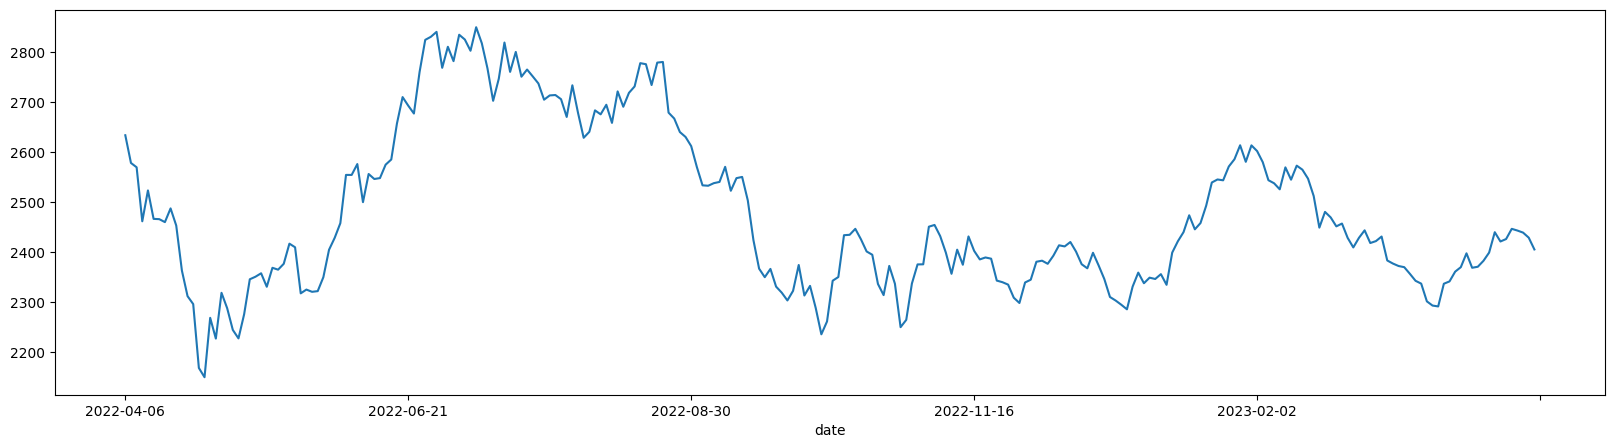

In [3]:
cyb = ak.stock_zh_index_daily(symbol="sz399006").iloc[-250:]
cyb = cyb.set_index("date")
cyb.index = cyb.index.astype(str)
cyb.close.plot(figsize=(20,5))

**4.使用移动平均线进行平滑**

移动平均线（Moving Average，简称MA）是最简单的金融数据平滑方法，它通过计算一段时间内的数据的算术平均数来消除价格波动的噪声，使数据变化的趋势更加清晰。

<Axes: xlabel='date'>

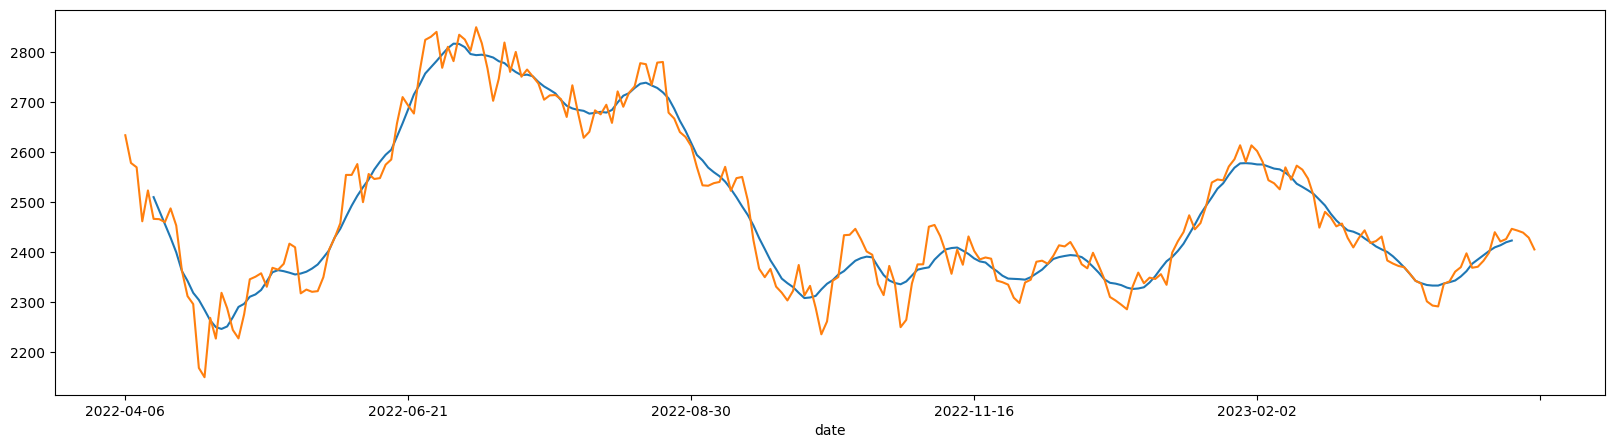

In [4]:
def ma_smooth(data, window_length, center=True):
  if isinstance(data, pd.Series):
    smooth = data.rolling(window_length, center=center).mean()
  else:
    data = pd.Series(data)
    smooth = data.rolling(window_length, center=center).mean().values

  return smooth


ma_smooth(cyb.close, 10).plot(figsize=(20,5))
cyb.close.plot(figsize=(20,5))

**5.使用Savitzky-Golay滤波器平滑**

Savitzky-Golay 滤波器是一种数字信号处理中的平滑滤波器，它在许多领域中都得到广泛应用，包括时间序列和图像处理。该滤波器使用基本思想是对原始数据进行多项式拟合，从而估计平滑后的数据，并在拟合过程中去除噪声和异常值。相比于传统平均滤波器，Savitzky-Golay 滤波器更适用于非线性信号和不同窗口大小下的平滑滤波。

<Axes: xlabel='date'>

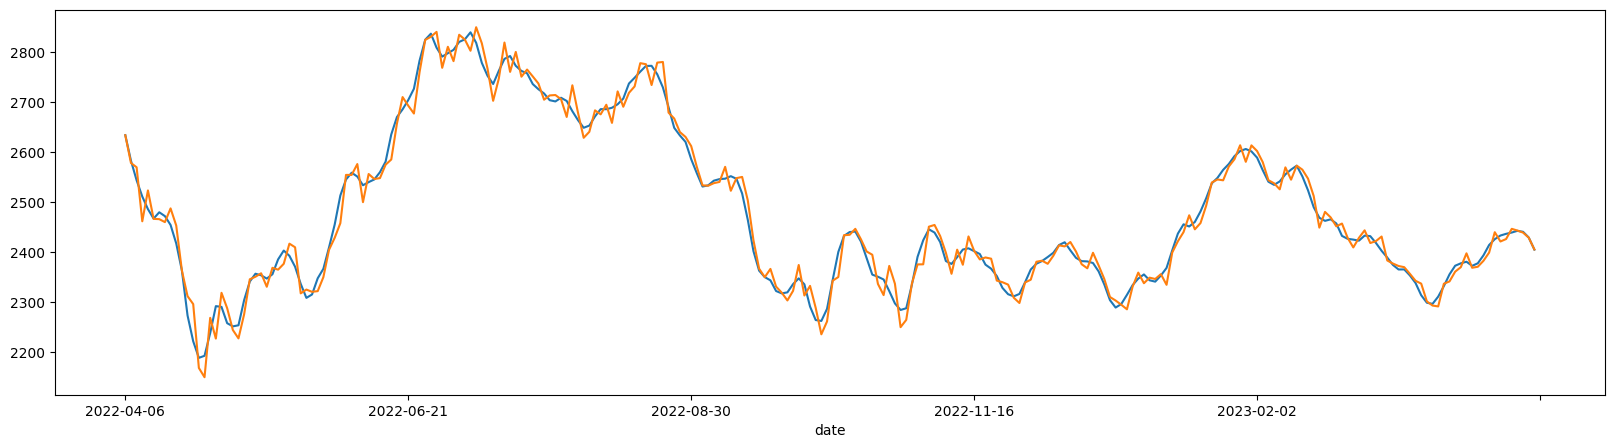

In [5]:
def savgol_filter_smooth(data, window_length, polyorder=5):
  if isinstance(data, pd.Series):
    smooth = savgol_filter(data, window_length = window_length, polyorder = polyorder)
    smooth = pd.Series(smooth, index=data.index)
  else:
    smooth = savgol_filter(data, window_length = window_length, polyorder = polyorder)
  
  return smooth


savgol_filter_smooth(cyb.close, 10).plot(figsize=(20,5))
cyb.close.plot(figsize=(20,5))

**6.使用偏微分方程平滑**

使用偏微分方程（Partial Differential Equations，PDEs）来平滑数据是一种常见的方法。偏微分方程有许多种类型，但其中最常用的就是热传导方程和Perona-Malik PDE。它们的基本思想是通过计算数据点之间的差异来确定数据点的变化速率，并根据这些速率来调整数据以获得更平滑的曲线。

<Axes: xlabel='date'>

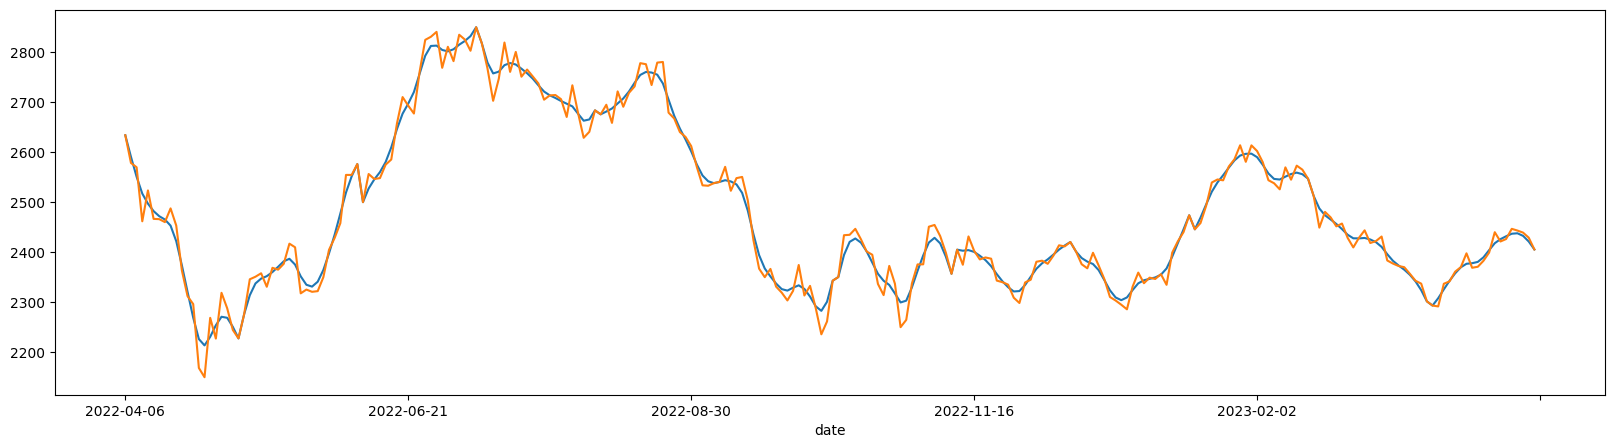

In [6]:
def get_diff_mat(n: int):
    '''
    Get the first and second differentiation matrices, which are truncated
    to find the derivative on the interior points.
    Parameters
    ----------
    n : int
        The total number of discrete points
    Returns
    -------
    [Dx, Dxx] : np.array
        The first and second differentiation matrices, respecitvely.
    '''
    
    Dx = (
        np.diag(np.ones(n-1), 1) 
        - np.diag(np.ones(n-1), -1)
    )/2
    
    Dxx = (
        np.diag(np.ones(n-1), 1)
        - 2*np.diag(np.ones(n), 0)
        + np.diag(np.ones(n-1), -1)
    )
    
    # Truncate the matrices so that we only determine the derivative on the
    # interior points (i.e. we don't calculate the derivative on the boundary)
    return Dx[1:-1, :], Dxx[1:-1, :]
    
def _heat_smooth(p: np.array,
        k: float = 0.05,
        t_end: float = 5.0) -> np.array:
    '''
    Solve the heat equation using a basic finite difference approach.
    Parameters
    ----------
    p : np.array
        The price array to smoothen.
    k : float, optional
        The step size in time (keep < 0.1 for accuracy)
    t_end : float, optional
        When to termininate the algorithm the larger the t_end, the smoother
        the series
    Returns
    -------
    U : np.array
        The heat equation smoothened time series
    '''
    _, Dxx = get_diff_mat(p.shape[0])
    
    U = deepcopy(p)
    t = 0
    
    while t < t_end:

        U = np.hstack((
            np.array([p[0]]),
            U[1:-1] + k*Dxx@U,
            np.array([p[-1]]),
        ))
        
        t += k
        
    return U

def heat_smooth(data, k=0.05, t_end=1, window=21):
  if isinstance(data, pd.Series):
    smooth = data.values.copy()
    for i in range(0, len(smooth), window):
        smooth[i:i+window] = _heat_smooth(smooth[i:i+window], k, t_end)
    smooth = pd.Series(smooth, index=data.index)
  else:
    smooth = data.copy()
    for i in range(0, len(smooth), window):
        smooth[i:i+window] = _heat_smooth(smooth[i:i+window], k, t_end)
    smooth = _heat_smooth(data, k, t_end)
  
  return smooth


heat_smooth(cyb.close).plot(figsize=(20,5))
cyb.close.plot(figsize=(20,5))